# Projet 4 : Anticipez le retard de vol des avions

# Modèles de prédiction

## Contexte

La compagnie AirData souhaite optimiser la logistique et anticiper les retards de vols. Pour celà, elle nous fournit des données de vols de 2016 de différentes compagnies et nous demande de les analyser afin d'implémenter un modèle de prédiction des retards.

**L'objectif** de la mission est donc de faire une analyse exploratoire des données, puis tester différents modèles de prédiction afin d'en séléctionner un afin de l'implémenter dans une API Web de prédiction de retard.

Ce notebook traite des **tests des différents modèles de machine learning** pour notre problématique de prédiction de retard. Il fait suite au notebook **Analyse exploratoire des données**.

In [1]:
# On importe toutes les librairies nécessaires
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import random

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 1. Importation des données

In [2]:
flightsDB= pd.read_csv('flightsDB.csv')

In [3]:
flightsDB.shape

(5556195, 16)

In [4]:
flightsDB.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,ARR_DELAY,DISTANCE,WEEK_NUM,H_DAYS,DEP_HOUR,CARRIER_CODE,ORIGIN_CODE,DEST_CODE
0,9,1,4,2016-09-01,AA,1,BOS,JFK,-23.0,187.0,35,4,6,0,38,157
1,9,2,5,2016-09-02,AA,1,BOS,JFK,-6.0,187.0,35,3,6,0,38,157
2,9,6,2,2016-09-06,AA,1,BOS,JFK,-19.0,187.0,36,1,6,0,38,157
3,9,8,4,2016-09-08,AA,1,BOS,JFK,-27.0,187.0,36,3,6,0,38,157
4,9,9,5,2016-09-09,AA,1,BOS,JFK,-21.0,187.0,36,4,6,0,38,157


## 2. Selection des données

Notre objectif est de proposer une API pour la prédiction des retards. Pour celà, on va demander à l'utilisateur
de rentrer :
- Le Mois (MONTH)
- Le jour (DAY_OF_MONTH)
- Le jour de la semaine (DAY_OF_WEEK)
- La compagnie aérienne (UNIQUE_CARRIER_CODE)
- Le lieu de départ (ORIGIN_CODE)
- Le lieu d'arrivée (DEST_CODE)
- L'heure de départ (DEP_HOUR)
    
Nous allons pouvoir calculer la distance (DISTANCE), le nombre de jours proches de jours fériés (H_DAYS) et le numéro de semaine (WEEK_NUM)

Nous n'allons pas utiliser le numéro de vol qui est finalement une combinaison du trajet, de la compagnie et des dates/heures du voyage.

## 3. Pistes de modélisation

In [5]:
# Affichage sous forme de graphe d'un sample de valeurs prédites et la valeurs réels
def displayPredictedVsReal(y_true,y_pred, nb_sample, title) :
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    x = random.sample(range(0, len(y_true)), nb_sample)
    x=np.sort(x) 
    y1 = y_true[x]
    y2 = y_pred[x]
    ax.plot(x, y1,linestyle='-', marker='x', label='Réel')
    ax.plot(x, y2,'k--', c='r', marker='o', label='Prédiction')
    ax.set_title(title)
    plt.legend(loc='upper left');
    plt.show()

In [6]:
# Recherche sur grille et cross validation pour tester différents paramètres de l'algorithme SGDRegressor
# Affiche les paramètres qui donne la meilleure performance ainsi que la MAE, MSE
# Retourne les valeurs mesurées et les valeurs prédites
def evaluateRegressor(x_train, y_train):
    param_grid = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['squared_loss', 'huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'l1_ratio':[.05, .15, .5, .7, .9, .95, .99, 1]}
    model = SGDRegressor()
    clf = GridSearchCV(model, param_grid,cv=5, n_jobs=8)
    clf.fit(x_train, y_train)
    print("Best score: " + str(clf.best_score_))
    print(clf.best_estimator_)
    y_true, y_pred = y_test, clf.predict(x_test)
    print("MSE", mean_squared_error(y_test, y_pred))
    print("MAE", mean_absolute_error(y_test, y_pred))
    print("Best parameters:",clf.best_params_)
    return y_true, y_pred

In [7]:
# Affichage de la distribution des résidus de la regression
def displayResiduals(y_true, y_pred) :
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.distplot(residuals, color='b',bins=20);
    plt.ylabel('Count')
    plt.xlabel('Residuals')

### 3.1 Sample des données à 10%

On prend un échantillon de 10% des données pour faire les tests de nos modèles pour éviter les problèmes de performance.

In [8]:
data = flightsDB.sample(frac=0.1)

#### Préparation des données

Nous devons traiter nos données pour avoir un one-hot encoding pour les variables categorielle et normer/centrer les variables numériques.

In [9]:
# Les variables numérique selectionnées pour l'apprentissage
scalingDF = data[['DISTANCE', 'H_DAYS']].astype('float')

# Les variables categorielle selectionnées pour l'apprentissage
categDF = data[['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'WEEK_NUM',
                     'DEP_HOUR', 'CARRIER_CODE', 'ORIGIN_CODE', 'DEST_CODE']] 

On encode les variables catégorielle pour qu'on puisse les utiliser dans les algorithmes de ML.<br/>
Permet de faire de la “binarization” de la variable pour appliquer algorithme d'apprentissage

In [10]:
encoder = OneHotEncoder() 
categDF_encoded = encoder.fit_transform(categDF)

In [11]:
type(categDF_encoded)

scipy.sparse.csr.csr_matrix

Le type est une Sparce Row Matrice compressée. On transforme nos données numériques en sparse matrice aussi.

In [12]:
scalingDF_sparse = sparse.csr_matrix(scalingDF)

#### On construit notre X

In [13]:
x_final = sparse.hstack((scalingDF_sparse, categDF_encoded))

#### La target variable est ARR_DELAY

In [14]:
y_final = data['ARR_DELAY'].values

#### Séparons nos données en un jeu d’entraînement et un jeu de test

On sépare en 70% pour entrainement et 30% pour les tests

In [15]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_final,y_final,test_size = 0.3,random_state = 0)

#### Standardisation des données numériques

On applique un Scaler pour centrer normer nos données numériques

In [16]:
x_train_numerical = x_train[:, 0:2].toarray() # We only want the first two features which are the numerical ones.
x_test_numerical = x_test[:, 0:2].toarray()

In [17]:
scaler = StandardScaler() # create scaler object
scaler.fit(x_train_numerical) # fit with the training data ONLY
x_train_numerical = sparse.csr_matrix(scaler.transform(x_train_numerical)) # Transform the data and convert to sparse
x_test_numerical = sparse.csr_matrix(scaler.transform(x_test_numerical))

In [18]:
x_train[:, 0:2] = x_train_numerical
x_test[:, 0:2] = x_test_numerical

/Users/hatim/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


#### Evaluation des modèles

- Nous testons différents modèles et hyper-paramètres de régressions linéaires en faisant de la validation croisée pour déterminer les meilleurs valeurs des paramètres et avoir une moyenne de l'erreur.
- Pour analyser le modèle, nous regardons l'erreur moyenne absolue et l'erreur moyenne quadratique. 
- Nous affichons aussi dans un graphe la comparaison entre valeur prédite et valeur réelle pour un échantillon de données. Celà nous permettra de visualiser la fiabilité du modèle.
- Nous affichons aussi la distribution des résidus pour nous permettre de valider la qualité de la modélisation.

In [19]:
y_true, y_pred = evaluateRegressor(x_train, y_train)

/Users/hatim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Best score: 0.038077616767
SGDRegressor(alpha=1.0000000000000001e-05, average=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.05,
       learning_rate='invscaling', loss='squared_loss', max_iter=5,
       n_iter=None, penalty='elasticnet', power_t=0.25, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
MSE 1642.87940497
MAE 21.089428023
Best parameters: {'alpha': 1.0000000000000001e-05, 'l1_ratio': 0.05, 'loss': 'squared_loss', 'penalty': 'elasticnet'}


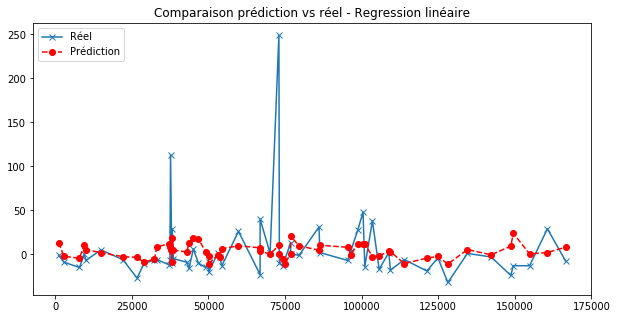

In [21]:
displayPredictedVsReal(y_true, y_pred,60,'Comparaison prédiction vs réel - Regression linéaire')

=> Nous constations que les prédictions sont proches de retards réels sauf dans le cas de retards extrêmes (ou avances extrêmes)

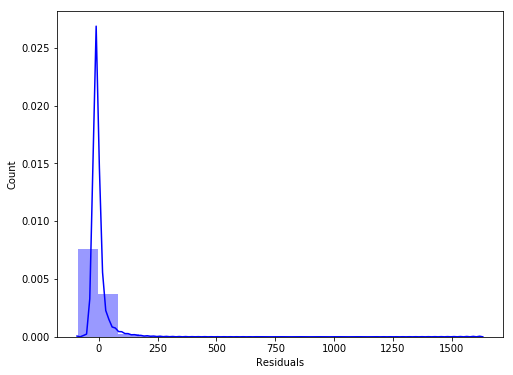

In [22]:
displayResiduals(y_true, y_pred)

- Pics des résidus entre -50 et 50 puis une longue traine après 200.
- Nous n'avons pas une distribution régulière des résidus ce qui ne conforte pas beaucoup notre modèle.
- Pas de distribution normale des résidus.

#### Analyse des résultats

| Types	                                                          | MSE  	| MAE	| Best Params		           |
|-----------------------------------------------------------------|-------------|-------|----------------------------------|
| loss=squared_loss, penalty = elasticnet			              | 1642	| 21,08	| alpha = 0,000001, l1_ratio = 0,05		   |

Nous avons le meilleur score pour une perte de type **quadratique** et une pénalité **elasticnet**. 
Dans les graphiques, nous voyons que les prédictions sont proches de valeurs réels autour de zéro mais elles deviennent mauvaises au niveau des extrêmes.
Nous n'avons pas de distribution normale pour les résidus ce qui ne conforte pas beaucoup nos hypothèses de modélisation.

---

### 3.2 Sample avec suppression des avances (on garde uniquement les retards)

On supprime tous les retards qui sont négatifs car notre objectif final est de construire une API qui prédit les retards 
(les avances ont un peu moins d'intérêt pour l'utilisateur). Et voir si on a une meilleur prédiction avec ce dataset

In [44]:
data = flightsDB[flightsDB["ARR_DELAY"] >= 0]

In [45]:
data.shape

(2006499, 16)

##### Sample 25% (car on a supprimé pas mal de données)

In [46]:
data = data.sample(frac=0.25)

#### Préparation des données

In [47]:
# Les variables numérique selectionnées pour l'apprentissage
scalingDF = data[['DISTANCE', 'H_DAYS']].astype('float')

# Les variables categorielle selectionnées pour l'apprentissage
categDF = data[['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'WEEK_NUM',
                     'DEP_HOUR', 'CARRIER_CODE', 'ORIGIN_CODE', 'DEST_CODE']] 

encoder = OneHotEncoder() 
categDF_encoded = encoder.fit_transform(categDF)

scalingDF_sparse = sparse.csr_matrix(scalingDF)

x_final = sparse.hstack((scalingDF_sparse, categDF_encoded))
y_final = data['ARR_DELAY'].values

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_final,y_final,test_size = 0.3,random_state = 0)

x_train_numerical = x_train[:, 0:2].toarray() # We only want the first two features which are the numerical ones.
x_test_numerical = x_test[:, 0:2].toarray()

scaler = StandardScaler() # create scaler object
scaler.fit(x_train_numerical) # fit with the training data ONLY
x_train_numerical = sparse.csr_matrix(scaler.transform(x_train_numerical)) # Transform the data and convert to sparse
x_test_numerical = sparse.csr_matrix(scaler.transform(x_test_numerical))

x_train[:, 0:2] = x_train_numerical
x_test[:, 0:2] = x_test_numerical

/Users/hatim/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


#### Evaluation des modèles

/Users/hatim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Best score: 0.0392150372122
SGDRegressor(alpha=9.9999999999999995e-07, average=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.9,
       learning_rate='invscaling', loss='squared_loss', max_iter=5,
       n_iter=None, penalty='l1', power_t=0.25, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
MSE 3173.18747698
MAE 31.1319101101
Best parameters: {'alpha': 9.9999999999999995e-07, 'l1_ratio': 0.9, 'loss': 'squared_loss', 'penalty': 'l1'}


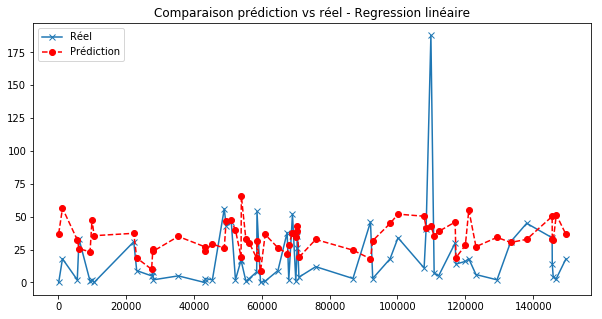

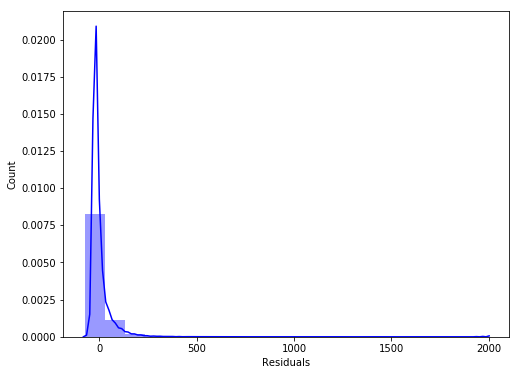

In [48]:
y_true, y_pred = evaluateRegressor(x_train, y_train)
displayPredictedVsReal(y_true, y_pred,60,'Comparaison prédiction vs réel - Regression linéaire')
displayResiduals(y_true, y_pred)

- On constate un peu de moins de décalage pour les retards extrêmes mais la distribution des résidus n'est toujours pas régulière. 

- Le score MAE est par contre beaucoup moins bon que dans le scéanario précédemment

#### Analyse des résultats

| Types	                                                          | MSE  	| MAE	| Best Params		           |
|-----------------------------------------------------------------|-------------|-------|----------------------------------|
| loss=squared_loss, penalty = l1			              | 3173	| 31,13	| alpha = 0,0000001		   |

=> Les résultats (notamment le MAE) est beaucoup moins bon que dans le scénario précédent.

=> La distribution des résidus n'est pas régulière

=> Ce scénario ne sera donc pas privilégié

---

### 3.3 Sample avec suppression des valeurs extrêmes

Les valeurs extrêmes sont souvent causées par des évènements exceptionnels qu'il est difficile de prédire. Voyons donc si on améliore notre modèle en supprimant ces valeurs.

On supprime les 2,5% de vols qui ont le moins de retard et 5% qui ont le plus.

In [100]:
q_max = flightsDB["ARR_DELAY"].quantile(0.95)
q_min = flightsDB["ARR_DELAY"].quantile(0.025)

In [101]:
data = flightsDB[flightsDB["ARR_DELAY"] > q_min]
data = data[data["ARR_DELAY"] < q_max]

On regarde la distribution des retards sans les valeurs extrêmes.

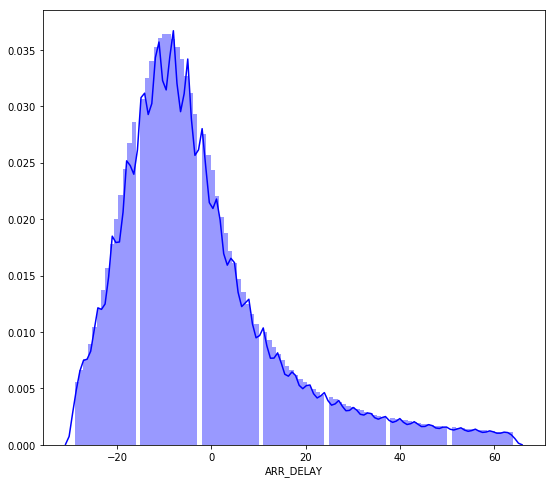

In [102]:
plt.figure(figsize=(9, 8))
sns.distplot(data['ARR_DELAY'], color='b',bins=100);

=> On constate qu'il y a une majorité de vols qui sont soit en avance ou à l'heure. <br/>
=> Les retards sont pour la plupart < 10 min

##### Sample 10%

In [103]:
data = data.sample(frac=0.1)

#### Préparation des données

In [104]:
# Les variables numérique selectionnées pour l'apprentissage
scalingDF = data[['DISTANCE', 'H_DAYS']].astype('float')

# Les variables categorielle selectionnées pour l'apprentissage
categDF = data[['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'WEEK_NUM',
                     'DEP_HOUR', 'CARRIER_CODE', 'ORIGIN_CODE', 'DEST_CODE']] 

encoder = OneHotEncoder() 
categDF_encoded = encoder.fit_transform(categDF)

scalingDF_sparse = sparse.csr_matrix(scalingDF)

x_final = sparse.hstack((scalingDF_sparse, categDF_encoded))
y_final = data['ARR_DELAY'].values

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_final,y_final,test_size = 0.3,random_state = 0)

x_train_numerical = x_train[:, 0:2].toarray() # We only want the first two features which are the numerical ones.
x_test_numerical = x_test[:, 0:2].toarray()

scaler = StandardScaler() # create scaler object
scaler.fit(x_train_numerical) # fit with the training data ONLY
x_train_numerical = sparse.csr_matrix(scaler.transform(x_train_numerical)) # Transform the data and convert to sparse
x_test_numerical = sparse.csr_matrix(scaler.transform(x_test_numerical))

x_train[:, 0:2] = x_train_numerical
x_test[:, 0:2] = x_test_numerical

/Users/hatim/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


#### Evaluation des modèles

/Users/hatim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Best score: 0.0612989827643
SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.9, learning_rate='invscaling',
       loss='squared_loss', max_iter=5, n_iter=None, penalty='elasticnet',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
MSE 272.844612792
MAE 12.2446843663
Best parameters: {'alpha': 0.0001, 'l1_ratio': 0.9, 'loss': 'squared_loss', 'penalty': 'elasticnet'}


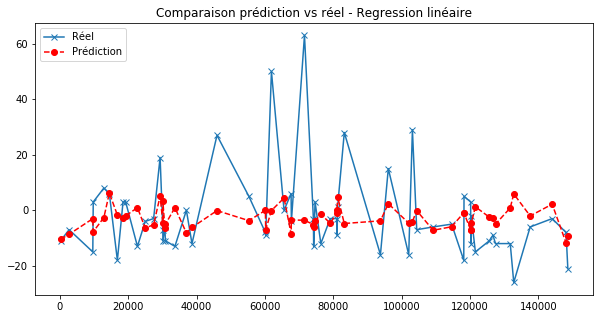

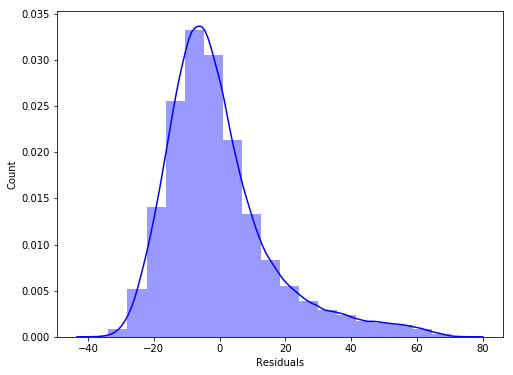

In [105]:
y_true, y_pred = evaluateRegressor(x_train, y_train)
displayPredictedVsReal(y_true, y_pred,60,'Comparaison prédiction vs réel - Regression linéaire')
displayResiduals(y_true, y_pred)

- le score MAE est meilleur que les scénarii précédents
- On a toujours quelques écarts entre valeurs réelles et prédites lorsque les retards ou avances sont importants
- la distribution des résidus est plus régulière que dans les autres tests

#### Analyse des résultats

| Types	                                                          | MSE  	| MAE	| Best Params		           |
|-----------------------------------------------------------------|-------------|-------|----------------------------------|
| loss=squared_loss, penalty = eslastic-net			              | 272	| 12,24	| alpha = 0,0001, l1_ratio=0,9		   |

=> Les résultats (MAE) sont meilleurs de tous nos scéanarii<br/>
=> L'écart entre valeurs prédites et réels est plus élevé dans le cas de retards ou avances importants mais moindre que ceux des 2 autres cas testés précédement.<br/>
=> la distribution des résidus n'est pas complétement normale mais elle s'en approche<br/>
=> **squared_loss** donne de meilleur résultat que la perte de **Huber**

### 3.4 Sample avec équilibrage des retards et avances et suppression des données extrêmes

On supprime les valeurs extrêmes puis on prend un sample dans lequel on cherche à équilibrer le nombre de vols avec retards et vols avec avance.

In [71]:
q_max = flightsDB["ARR_DELAY"].quantile(0.90)
q_min = flightsDB["ARR_DELAY"].quantile(0.025)

data = flightsDB[flightsDB["ARR_DELAY"] > q_min]
data = data[data["ARR_DELAY"] < q_max]

On prend un sample de 250 000 retards et 250 000 avances.

In [72]:
data1 = data[data['ARR_DELAY'] > 0].sample(n=250000)
data2 = data[data['ARR_DELAY'] <= 0].sample(n=250000)
data = data1.append(data2)

In [73]:
data.shape

(500000, 16)

#### Préparation des données

In [74]:
# Les variables numérique selectionnées pour l'apprentissage
scalingDF = data[['DISTANCE', 'H_DAYS']].astype('float')

# Les variables categorielle selectionnées pour l'apprentissage
categDF = data[['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'WEEK_NUM',
                     'DEP_HOUR', 'CARRIER_CODE', 'ORIGIN_CODE', 'DEST_CODE']] 

encoder = OneHotEncoder() 
categDF_encoded = encoder.fit_transform(categDF)

scalingDF_sparse = sparse.csr_matrix(scalingDF)

x_final = sparse.hstack((scalingDF_sparse, categDF_encoded))
y_final = data['ARR_DELAY'].values

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_final,y_final,test_size = 0.3,random_state = 0)

x_train_numerical = x_train[:, 0:2].toarray() # We only want the first two features which are the numerical ones.
x_test_numerical = x_test[:, 0:2].toarray()

scaler = StandardScaler() # create scaler object
scaler.fit(x_train_numerical) # fit with the training data ONLY
x_train_numerical = sparse.csr_matrix(scaler.transform(x_train_numerical)) # Transform the data and convert to sparse
x_test_numerical = sparse.csr_matrix(scaler.transform(x_test_numerical))

x_train[:, 0:2] = x_train_numerical
x_test[:, 0:2] = x_test_numerical

/Users/hatim/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


#### Evaluation des modèles

##### Régression linéaire multiple sans pénalité 

/Users/hatim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Best score: 0.0580244458617
SGDRegressor(alpha=1.0000000000000001e-05, average=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.9,
       learning_rate='invscaling', loss='squared_loss', max_iter=5,
       n_iter=None, penalty='l1', power_t=0.25, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
MSE 177.325376491
MAE 10.902927307
Best parameters: {'alpha': 1.0000000000000001e-05, 'l1_ratio': 0.9, 'loss': 'squared_loss', 'penalty': 'l1'}


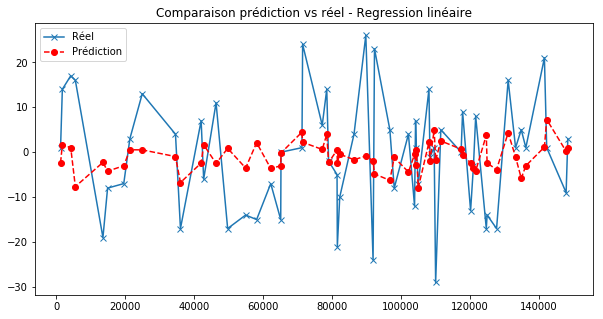

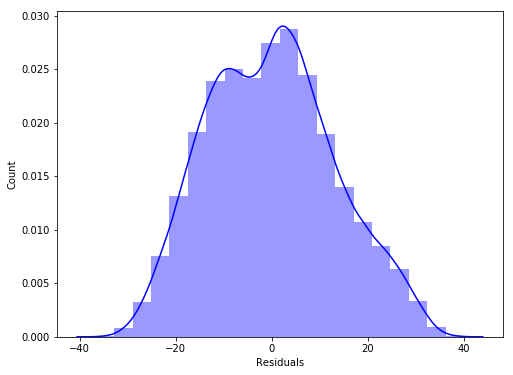

In [75]:
#y_true, y_pred = evaluateSGDRegressor(x_train, y_train,'squared_loss')
y_true, y_pred = evaluateRegressor(x_train, y_train)
displayPredictedVsReal(y_true, y_pred,60,'Comparaison prédiction vs réel - Regression linéaire')
displayResiduals(y_true, y_pred)

- le score MAE est meilleur que les scénarii précédents
- On a toujours quelques écarts entre valeurs réelles et prédites mais globalement on s'éloigne moins
- la distribution des résidus est plus régulière et meilleure que le scénario précédent

#### Analyse des résultats

| Types	                                                          | MSE  	| MAE	| Best Params		           |
|-----------------------------------------------------------------|-------------|-------|----------------------------------|
| loss=squared_loss, penalty = l1			              | 177	| 10,90	| alpha = 0,000001		   |

=> Les scores MAE et MSE sont améliorés par rapport aux scénarii précédents<br/>
=> La perte quadratique donne de meilleurs résultats qu'avec la perte Huber (nous avons supprimé les extrêmes).<br/>
=> La distribution des résidus est plus régulière.<br/>
=> Nous allons donc conserver ce scénario avec comme choix : une régression linéaire avec perte quadratique et pénalisé par Lasso avec les paramètres alpha = 0,00001<br/>

## 4. Modèle final

On prend l'ensemble des données et on applique le modèle séléctionné

In [84]:
q_max = flightsDB["ARR_DELAY"].quantile(0.90)
q_min = flightsDB["ARR_DELAY"].quantile(0.025)

data = flightsDB[flightsDB["ARR_DELAY"] > q_min]
data = data[data["ARR_DELAY"] < q_max]

In [87]:
# On prend sample avec équilibrage entre retards et avances
# Nous avons plus d'avances que de retards
num_delayed = data[data['ARR_DELAY'] > 0]['ARR_DELAY'].count()

data1 = data[data['ARR_DELAY'] > 0].sample(n=num_delayed)
data2 = data[data['ARR_DELAY'] <= 0].sample(n=num_delayed)
data = data1.append(data2)

In [88]:
# Les variables numérique selectionnées pour l'apprentissage
scalingDF = data[['DISTANCE', 'H_DAYS']].astype('float')

# Les variables categorielle selectionnées pour l'apprentissage
categDF = data[['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'WEEK_NUM',
                     'DEP_HOUR', 'CARRIER_CODE', 'ORIGIN_CODE', 'DEST_CODE']] 

encoder = OneHotEncoder() 
categDF_encoded = encoder.fit_transform(categDF)

scalingDF_sparse = sparse.csr_matrix(scalingDF)

x_final = sparse.hstack((scalingDF_sparse, categDF_encoded))
y_final = data['ARR_DELAY'].values

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_final,y_final,test_size = 0.3,random_state = 0)

x_train_numerical = x_train[:, 0:2].toarray() # We only want the first two features which are the numerical ones.
x_test_numerical = x_test[:, 0:2].toarray()

scaler = StandardScaler() # create scaler object
scaler.fit(x_train_numerical) # fit with the training data ONLY
x_train_numerical = sparse.csr_matrix(scaler.transform(x_train_numerical)) # Transform the data and convert to sparse
x_test_numerical = sparse.csr_matrix(scaler.transform(x_test_numerical))

x_train[:, 0:2] = x_train_numerical
x_test[:, 0:2] = x_test_numerical

/Users/hatim/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


On choisit le modèle qui a donné les meilleurs résultats :
    - alpha = 0,00001
    - loss = 'squared_loss'
    - penalty = 'l1'

In [89]:
model = SGDRegressor(loss='squared_loss',penalty='l1',alpha=10.0**-5)
model.fit(x_train, y_train)

/Users/hatim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDRegressor(alpha=1e-05, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5, n_iter=None, penalty='l1',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [90]:
y_true, y_pred = y_test, model.predict(x_test)
MAE = mean_absolute_error(y_true, y_pred)
print('MAE {:.2f} \n'.format(MAE))

MAE 10.86 



## 5. Sauvegarde du modèle selectionné

On sauvegarde les différents élèments qui seront nécessaires à l'API de prédiction.

### Sauvegarde du modèle

In [91]:
from sklearn.externals import joblib
joblib.dump(model, 'flights_delays_model.pkl')

['flights_delays_model.pkl']

#### Sauvegarder encoder et scaler 

In [92]:
joblib.dump(encoder, 'categ_featuresEncoder.pkl')

['categ_featuresEncoder.pkl']

In [93]:
joblib.dump(scaler, 'numfeaturesScaler.pkl')

['numfeaturesScaler.pkl']

### Sauvegarde des données nécessaires à notre API

#### Codes aéroports

On récupère le mapping entre code et nom de l'aéroport'

In [94]:
airports_list= pd.read_csv('L_AIRPORT.csv')
airports_list.columns = ['AIRPORT_CODE', 'DESCRIPTION']

On construit la table contenant le lien entre code de l'aéroport et le code numérique dans notre base de vols

In [95]:
originCodes = flightsDB[['ORIGIN','ORIGIN_CODE']].drop_duplicates()
originCodes.columns = ['AIRPORT_CODE', 'ORIGIN_CODE']

destinationCodes = flightsDB[['DEST','DEST_CODE']].drop_duplicates()
destinationCodes.columns = ['AIRPORT_CODE', 'DEST_CODE']

aiportCodesData = pd.merge(originCodes, destinationCodes)

On sauve les données

In [96]:
aiportCodesData.to_pickle("airportCodesDF.pkl")

#### Liste des aéroports

Pour l'affichage HTML on constuit un objet JSON qui contient la liste des aéroports (avec codes) qui est contenue dans notre base de vols.

In [97]:
aiportCodesData = pd.merge(aiportCodesData, airports_list)

In [98]:
aiportCodesData[['AIRPORT_CODE','DESCRIPTION']].to_json(orient='records')

'[{"AIRPORT_CODE":"BOS","DESCRIPTION":"Boston, MA: Logan International"},{"AIRPORT_CODE":"JFK","DESCRIPTION":"New York, NY: John F. Kennedy International"},{"AIRPORT_CODE":"LAX","DESCRIPTION":"Los Angeles, CA: Los Angeles International"},{"AIRPORT_CODE":"DFW","DESCRIPTION":"Dallas\\/Fort Worth, TX: Dallas\\/Fort Worth International"},{"AIRPORT_CODE":"OKC","DESCRIPTION":"Oklahoma City, OK: Will Rogers World"},{"AIRPORT_CODE":"OGG","DESCRIPTION":"Kahului, HI: Kahului Airport"},{"AIRPORT_CODE":"HNL","DESCRIPTION":"Honolulu, HI: Daniel K Inouye International"},{"AIRPORT_CODE":"SFO","DESCRIPTION":"San Francisco, CA: San Francisco International"},{"AIRPORT_CODE":"ORD","DESCRIPTION":"Chicago, IL: Chicago O\'Hare International"},{"AIRPORT_CODE":"MIA","DESCRIPTION":"Miami, FL: Miami International"},{"AIRPORT_CODE":"IAH","DESCRIPTION":"Houston, TX: George Bush Intercontinental\\/Houston"},{"AIRPORT_CODE":"DTW","DESCRIPTION":"Detroit, MI: Detroit Metro Wayne County"},{"AIRPORT_CODE":"SEA","DESCRI

#### Distances entre aéroports

On sauve les distances pour faciliter les calculs de prédictions

In [99]:
flightsDB["TRIP"] = flightsDB["ORIGIN"]+ "-" + flightsDB["DEST"]
distancesDF = flightsDB.drop_duplicates(['TRIP'])[['ORIGIN','DEST', 'DISTANCE']]
distancesDF.to_pickle("tripDistance.pkl")